In [1]:
# Several different ways of visualizing attention heads in Transformers.
# The sample sentence comes from Theodore Dreiser's Sister Carrie (1900).
#
# This notebook supports the publication of James E. Dobson, "On Reading and 
# Interpreting Black Box Deep Neural Networks," International Journal
# of Digital Humanities (2023). https://doi.org/10.1007/s42803-023-00075-w
#
# James E. Dobson
# Dartmouth College
# https://jeddobson.github.io/

import torch
from transformers import AutoTokenizer, GPT2Model
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt 
import numpy as np
from operator import itemgetter
import matplotlib
from IPython.display import display, HTML

In [2]:
# load GPT2 model
model = GPT2Model.from_pretrained('gpt2', 
                                  low_cpu_mem_usage=True,
                                  output_attentions=True,
                                  output_hidden_states=True)
tok = AutoTokenizer.from_pretrained("gpt2")

# end of sentence/text token padding
tok.pad_token = tok.eos_token

Loading the tokenizer from the `special_tokens_map.json` and the `added_tokens.json` will be removed in `transformers 5`,  it is kept for forward compatibility, but it is recommended to update your `tokenizer_config.json` by uploading it again. You will see the new `added_tokens_decoder` attribute that will store the relevant information.


In [3]:
def describe_model():
    config = model.config.__dict__
    print("Model type: {0} ({1})".format(config['model_type'],
                                         ' '.join(config['architectures'])))
    print("Vocab size: {0}".format(config['vocab_size']))
    print("Layers: {0}".format(config['n_layer']))
    print("Embedding width: {0}".format(config['n_embd']))
    print("Parameters:\n Output Attentions: {0}\n Output Hidden States: {1}"
          .format(config['output_attentions'],
                 config['output_hidden_states']))

In [4]:
describe_model()

Model type: gpt2 (GPT2LMHeadModel)
Vocab size: 50257
Layers: 12
Embedding width: 768
Parameters:
 Output Attentions: True
 Output Hidden States: True


In [5]:
def colormap(words,values):
    norm_values = (values - np.min(values))/np.ptp(values)
    cmap = matplotlib.cm.get_cmap('Greys')
    
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    for word, color in zip(words, norm_values):
        color = matplotlib.colors.rgb2hex(cmap(color)[:3])
        if color.startswith('#00'):
#        if color == '#000000':
            colored_string += template.replace('black;','white;').format(color, '&nbsp' + word + '&nbsp')
        else:
            colored_string += template.format(color, '&nbsp' + word + '&nbsp')        
    return colored_string

In [6]:
def visualize_heads(sentence,layer,norm=False):
    inp_tok = tok(sentence, padding=True,
              return_tensors="pt").to(next(model.parameters()).device)
    input_ids = inp_tok["input_ids"]

    # convert back to tokens
    tokens = [tok.decode(id).strip() for id in input_ids[0]]
    
    # generate attention mask
    attention_mask = torch.ones_like(input_ids)
    
    # obtain representation
    outputs = model(input_ids, 
                    attention_mask = attention_mask, 
                    output_attentions = True)

    # extract attention data as final item from ouput tuple
    attention_heads = outputs[-1]
    
    #  obtain results of all heads
    layer_data = attention_heads[layer].squeeze().detach().cpu().numpy()
    
    # display attention
    fig = plt.figure(figsize=(20, 20))
    for idx, scores in enumerate(layer_data):
        scores_np = np.array(scores)
        ax = fig.add_subplot(4, 3, idx+1)
        
        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(tokens)))
        ax.set_yticks(range(len(tokens)))

        ax.set_xticklabels(tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format("Head", idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

In [7]:
sentence = "She was very hungry, and the things she saw there awakened her desires, \
but the high prices held her attention."

# tokenize
inp_tok = tok(sentence, padding=True,
              return_tensors="pt").to(next(model.parameters()).device)
input_ids = inp_tok["input_ids"]

# convert back to tokens
tokens = [tok.decode(id).strip() for id in input_ids[0]]

# generate attention mask
attention_mask = torch.ones_like(input_ids)

# obtain representation
outputs = model(input_ids, 
                attention_mask=attention_mask, 
                output_attentions=True)

# extract attention data as final item from tuple
attention_heads = outputs[-1]

#  obtain results of all heads
layer_data = [head.squeeze().detach().cpu().numpy() for head in attention_heads]
layer_data = np.asarray(layer_data)

In [8]:
def display_mean_tk_heatmap(term,layers=False):
    tidx = tokens.index(term)
    if layers == False:
        values = list(np.mean([np.mean(layer,axis=0) for layer in layer_data[:, :, tidx, :]],axis=0))
        display(HTML(colormap(tokens,values)))
    else:
        for lidx, values in enumerate([np.mean(layer,axis=0) for layer in layer_data[:, :, tidx, :]]):
            print("Layer: {0}".format(lidx))
            display(HTML(colormap(tokens,values)))

In [9]:
# mean values across all attention heads
display_mean_tk_heatmap("attention",layers=False)

In [10]:
# mean values across attention heads on each layer
display_mean_tk_heatmap("attention",layers=True)

Layer: 0


Layer: 1


Layer: 2


Layer: 3


Layer: 4


Layer: 5


Layer: 6


Layer: 7


Layer: 8


Layer: 9


Layer: 10


Layer: 11


In [11]:
def display_tk_heatmap(term):
    tidx = tokens.index(term)
    for lidx, layer in enumerate(layer_data[:, :, tidx, :]):
        for hidx, head in enumerate(layer):
            
            print("layer:", lidx, "head",hidx)
            values = list(head)
            display(HTML(colormap(tokens,values)))

In [12]:
display_tk_heatmap("desires")

layer: 0 head 0


layer: 0 head 1


layer: 0 head 2


layer: 0 head 3


layer: 0 head 4


layer: 0 head 5


layer: 0 head 6


layer: 0 head 7


layer: 0 head 8


layer: 0 head 9


layer: 0 head 10


layer: 0 head 11


layer: 1 head 0


layer: 1 head 1


layer: 1 head 2


layer: 1 head 3


layer: 1 head 4


layer: 1 head 5


layer: 1 head 6


layer: 1 head 7


layer: 1 head 8


layer: 1 head 9


layer: 1 head 10


layer: 1 head 11


layer: 2 head 0


layer: 2 head 1


layer: 2 head 2


layer: 2 head 3


layer: 2 head 4


layer: 2 head 5


layer: 2 head 6


layer: 2 head 7


layer: 2 head 8


layer: 2 head 9


layer: 2 head 10


layer: 2 head 11


layer: 3 head 0


layer: 3 head 1


layer: 3 head 2


layer: 3 head 3


layer: 3 head 4


layer: 3 head 5


layer: 3 head 6


layer: 3 head 7


layer: 3 head 8


layer: 3 head 9


layer: 3 head 10


layer: 3 head 11


layer: 4 head 0


layer: 4 head 1


layer: 4 head 2


layer: 4 head 3


layer: 4 head 4


layer: 4 head 5


layer: 4 head 6


layer: 4 head 7


layer: 4 head 8


layer: 4 head 9


layer: 4 head 10


layer: 4 head 11


layer: 5 head 0


layer: 5 head 1


layer: 5 head 2


layer: 5 head 3


layer: 5 head 4


layer: 5 head 5


layer: 5 head 6


layer: 5 head 7


layer: 5 head 8


layer: 5 head 9


layer: 5 head 10


layer: 5 head 11


layer: 6 head 0


layer: 6 head 1


layer: 6 head 2


layer: 6 head 3


layer: 6 head 4


layer: 6 head 5


layer: 6 head 6


layer: 6 head 7


layer: 6 head 8


layer: 6 head 9


layer: 6 head 10


layer: 6 head 11


layer: 7 head 0


layer: 7 head 1


layer: 7 head 2


layer: 7 head 3


layer: 7 head 4


layer: 7 head 5


layer: 7 head 6


layer: 7 head 7


layer: 7 head 8


layer: 7 head 9


layer: 7 head 10


layer: 7 head 11


layer: 8 head 0


layer: 8 head 1


layer: 8 head 2


layer: 8 head 3


layer: 8 head 4


layer: 8 head 5


layer: 8 head 6


layer: 8 head 7


layer: 8 head 8


layer: 8 head 9


layer: 8 head 10


layer: 8 head 11


layer: 9 head 0


layer: 9 head 1


layer: 9 head 2


layer: 9 head 3


layer: 9 head 4


layer: 9 head 5


layer: 9 head 6


layer: 9 head 7


layer: 9 head 8


layer: 9 head 9


layer: 9 head 10


layer: 9 head 11


layer: 10 head 0


layer: 10 head 1


layer: 10 head 2


layer: 10 head 3


layer: 10 head 4


layer: 10 head 5


layer: 10 head 6


layer: 10 head 7


layer: 10 head 8


layer: 10 head 9


layer: 10 head 10


layer: 10 head 11


layer: 11 head 0


layer: 11 head 1


layer: 11 head 2


layer: 11 head 3


layer: 11 head 4


layer: 11 head 5


layer: 11 head 6


layer: 11 head 7


layer: 11 head 8


layer: 11 head 9


layer: 11 head 10


layer: 11 head 11


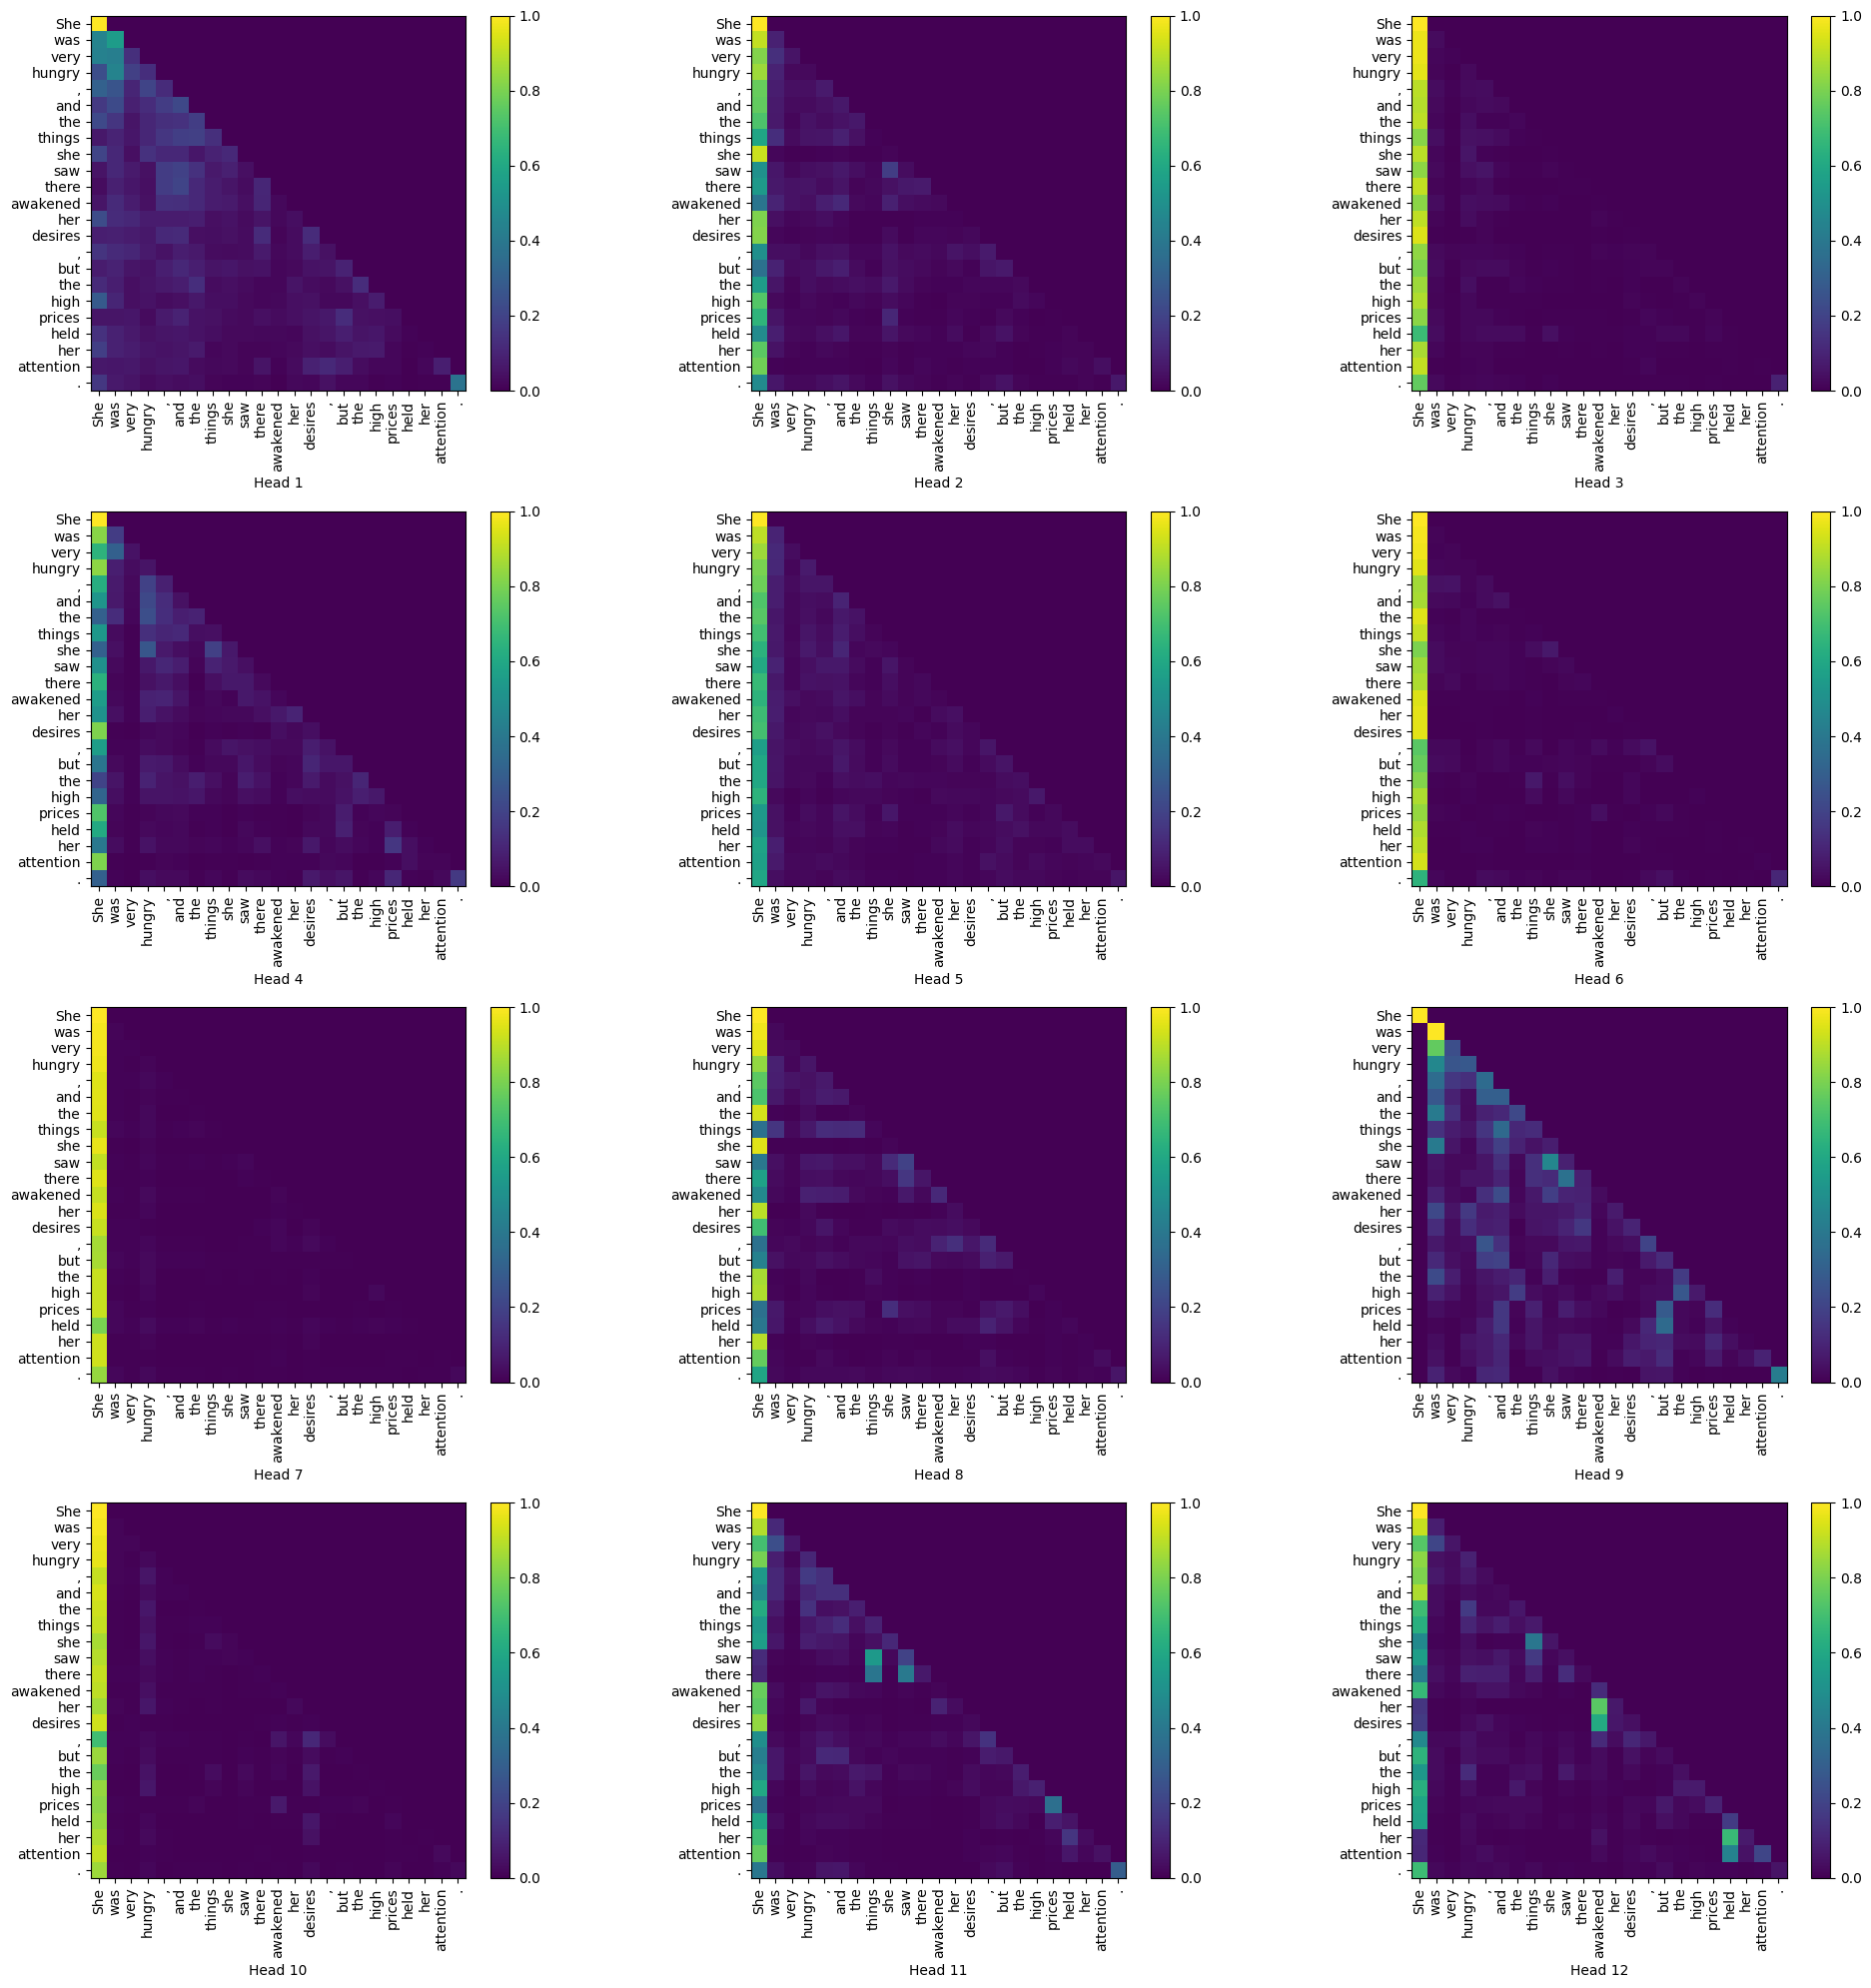

In [13]:
#sentence = """She walked bravely forward, led by an honest desire to find employment and delayed at every step by the interest of the unfolding scene, and a sense of helplessness amid so much evidence of power and force which she did not understand."""
visualize_heads(sentence,11)